Evolution of road movement at discrete timesteps:

1. Acceleration: If the velocity $v$ of a vehicle is lower than $v_{\max}$ and if the distance to the car ahead is larger than $v+1$, increase the speed by one $[v \mapsto v+1]$


In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from IPython.display import display, clear_output
rng = np.random.default_rng()

# had to include this so ffmpeg was included on my machine. ignore for now pls
plt.rcParams['animation.ffmpeg_path'] = "C:/Path_Programs/ffmpeg"

In [2]:
def animator(num_sol, anal_sol, x, times, nt, filename):
    '''
    Produces an animation of the analytical vs numerical solution of the concentration for all points 
    x on the strip where each frame of the animation corresponds to a time step 0 <= t <= T.
    
    Inputs: 
        - num_sol: array of size (nt,nx) with numerical solution of concentrations 
                    for all times t and points x on the strip.
        - anal_sol: array of size (nt,nx) with analytical solution of concentrations 
                    for all times t and points x on the strip.
        - x: vector of size nx containing points on the strip 0 <= x_i <= L.
        - times: vector of size nt containing times in the time period.
        - nt: number of discretised time steps for each frame in the animation.
        - filename: string denoting name of the .mp4 file which the animation will be saved as.
    
    Output:
        - Saved animation with same name as filename.
    '''
    
    # Setting initial frame
    fig, ax = plt.subplots()
    
    # Plotting solutions for initial frame
    line, = ax.plot(x, num_sol[0], c = 'orange', linewidth = 2.5, 
                    label = "Numerical solution") # plot numerical solution at t=0
    line2, = ax.plot(x, anal_sol[0], c = 'deeppink', linewidth = 3.5, linestyle = (0,(3,5,1,5,1,5)), 
                     label = "Analytical solution") # plot analytical solution at t=0
    ax.set(ylim=[0,0.6], xlabel = r'Distance $x$ from the dipping point (cm)', 
           ylabel = r'Concentration ($mol/cm^3$)')
    plt.legend(handlelength = 10)
    plt.grid(True)


    def update(i):  # To update each frame of the animation
            line.set_ydata(num_sol[i])
            line2.set_ydata(anal_sol[i])
            plt.title(f'Time = {times[i]:.2f} seconds')
            return (line, line2)

    ani = FuncAnimation(fig, update, frames=nt, blit=True, interval = 20)
    writer = animation.writers['ffmpeg'](fps=30)
    ani.save(filename, writer=writer, dpi=300)

In [2]:
def create_road(L):
    '''
    Set up a new, empty road
    '''
    return np.zeros((2,L), dtype=int)

In [3]:
def add_cars(L,n_cars):
    '''
    Set up a random road where a cell has nonzero velocity with probability p
    '''
    road = create_road(L)
    road[0, :n_cars] = 1
    rng.shuffle(road, axis = 1)

    return road



In [4]:
def initial_velocities(L, n_cars, vmax, road):
    '''
    Provide initial velocities to the cars
    '''
    random_vs = rng.integers(0, high = vmax, size = L, endpoint = True)
    road[1, :] = road[0, :]*random_vs

    return road


In [5]:
road_with_cars = add_cars(L = 15, n_cars = 5)
initial_road = initial_velocities(L = 15, n_cars = 5, vmax = 5, road=road_with_cars)

In [6]:
def plottable_road(road):
    road_plot = road.copy().astype(float)
    road_plot[1, (road_plot[0, :] == 0).astype(bool)] = np.nan
    return np.expand_dims(road_plot[1, :], axis=0), road_plot[1,:]

In [7]:
def plot_road(roads_to_plot, vmax):
    cmap = plt.get_cmap("jet", vmax)
    img = plt.imshow(roads_to_plot, cmap=cmap)
    plt.colorbar()

    return img


In [8]:
def animate_road(road, vmax):
    road1 = road.copy().astype(float)
    road1[1, (road1[0, :] == 0).astype(bool)] = np.nan

    cmap = plt.get_cmap("jet", vmax)
    img = plt.imshow(np.expand_dims(road1[1,:], axis=0), cmap = cmap, aspect="auto", animated=True)
    plt.colorbar(orientation="horizontal")

    return img


In [9]:
def get_site_value(road, site_num):
    '''Return the velocity of the vehicle on site i'''
    L = road.shape[1]
    return road[:, site_num%L]

In [10]:
def set_site_value(road, site_num, vel, empty):
    ''' Set the velocity (if any) of the vehicle on a site'''
    L = road.shape[1]
    if empty == False:   
        road[0, site_num%L] = 1
        road[1, site_num%L] = vel
    elif empty == True:
        road[:, site_num%L] = 0

    return road

In [11]:
def next_car_dist(road, site_num, L):
    '''
    Count the number of empty sites before 
    the next car (non-empty site)'''
    # site_status = np.where(road[0, :])[]
    j = site_num+1
    while road[0, j%L] == 0:
        j += 1
    
    # return index of next car and distance between current car and next
    return j%L, (j - site_num )%L


In [12]:
initial_road

array([[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 5, 4, 0, 0, 0, 0, 0, 4, 2, 0, 0]])

In [13]:
next_car_dist(initial_road, 4, L=15)

(5, 1)

In [14]:
def motion(road):
    L = road.shape[1]
    next_road = create_road(L)
    for site in range(L):
        site_stat = get_site_value(road, site)
        is_occupied = site_stat[0] == 1
        v = site_stat[1]
        if is_occupied:
            next_road = set_site_value(next_road, (site+v)%L, v, empty=False)
    
    return next_road

In [15]:
def step(road, vmax, prob):
    '''
    Creates the next iteration from a given road
    '''

    # create an empty road to store the new results in
    L = road.shape[1]
    road_info = road.copy()
    random_vec = rng.random(L)
    # loop over each site
    for site in range(L):

        # determine if the site is empty or occupied
        site_stat = get_site_value(road, site)
        is_occupied = site_stat[0] == 1
        v = site_stat[1]

        # apply the rules
        if is_occupied:
            # determine distance of car ahead
            dist_ahead = next_car_dist(road, site, L)[1]

        ## Acceleration
        # if the velocity v of a vehicle is lower than vmax and 
        # if the car distance to car ahead is larger than v+1, 
        # increase the speed by one (v -> v+1)
            if v < vmax and dist_ahead > v+1:
                road_info = set_site_value(road_info, site, v+1, empty=False)


            ## Deceleration
            # if a vehicle at site i sees the next vehicle at site i+j 
            # with j <= v, it reduces its speed to j-1 (v -> j-1)
            elif dist_ahead <= v:
                new_vel= dist_ahead-1
                road_info = set_site_value(road_info, site, new_vel, empty=False )


            ## Randomisation
            # with probability p, the vehicle's velocity is decreased 
            # by one to a minimum of zero ( v -> max(v-1, 0))
            elif random_vec[site] < prob:
                road_info = set_site_value(road_info, site, max([v-1, 0]), empty=False)

        ## Motion
        # each vehicle is advanced v sites
    next_road = motion(road_info)

    return next_road

In [67]:
new_road = step(initial_road, vmax = 5, prob = 0.01)

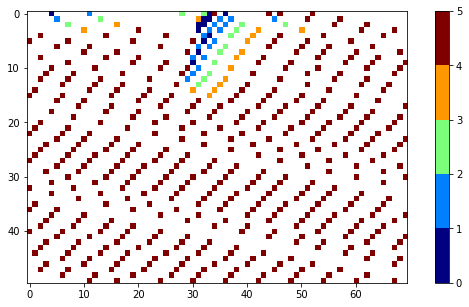

In [72]:
## Multiple iterations
nt = 50
L = 70
n_cars = 10
vmax = 5
prob = 0.5

roads_to_plot = np.zeros((nt, L))
initial_road = initial_velocities(L, n_cars, vmax, road=add_cars(L, n_cars))
next_road = initial_road

# mpl.rcParams['image.aspect']="auto"
roads_to_plot[0, :] = plottable_road(next_road)[1]

fig, ax = plt.subplots(figsize = (10,5))
# img = animate_road(next_road, vmax)

for i in range(nt-1):
    next_road = step(next_road, vmax, prob)
    roads_to_plot[i+1, :] = plottable_road(next_road)[1]
    # img.set_array(plottable_road(next_road)[0])
    # plt.pause(0.1)
    # clear_output(wait=True)
    # display(fig)


plot_road(roads_to_plot, vmax)

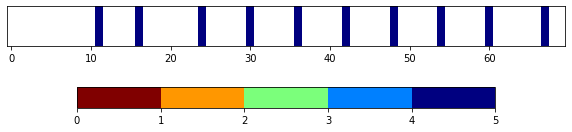

In [73]:
fig, ax = plt.subplots(figsize = (10, 5))
cmap = plt.get_cmap("jet_r", vmax)
img = ax.imshow(np.expand_dims(roads_to_plot[0,:], axis = 0), cmap=cmap, aspect=5, animated = True)
ax.get_yaxis().set_visible(False)
cbar = fig.colorbar(img, orientation="horizontal", shrink = 0.75)

def update(i):
    img.set_array(np.expand_dims(roads_to_plot[i,:], axis = 0))
    return [img]

ani = animation.FuncAnimation(fig, update, frames = nt, blit = True, interval = 20)
# writer = animation.writers["ffmpeg"](fps = 30)
FFwriter = animation.FFMpegWriter()
ani.save("test.mp4", writer = FFwriter, dpi = 300)